### 4 Service Level Analysis

In this section we will be looking at service levels and will cover the following topics:
* **When is the route serviced** - which hours of the day does each route have vehicles running on it.
* **How many vehicles** - we will look at both how many vehicles each route has over the course of the day as well as how many end-to-end trips are made by those vehicles as well as how long those trips take.
* **Average Wait Times** - if a passenger shows up at a stop, on average how long will it be before a vehicle comes, in this section we will only look at any vehicle servicing a stop

In [1]:
#import helperfunction.py
%run helperfunctions

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import psycopg2
import datetime
db = db_name

#uncomment if you want to analyse a different database from the one in your settings file
#db = 'ttctestii'

#### 4.1 Hours Serviced

We will count a route direction as being serviced if it has at least one bus transmitting as being active on that route direction for 15min or more.  We will use this data in later sections of the analysis, ie we will only calculate wait times on routes that actually have buses servicing it.

In [2]:
sql = """
select extract(hour from fn_epoch_to_dt(analysis_time)) hr, dirtag, routetag,  count(distinct id) vehicle_count
from calc_location_log_07 l
group by extract(hour from fn_epoch_to_dt(analysis_time)), dirtag, routetag 
having count(*) >= 30
"""

gdf_active_routes = getsql(sql, db)

Here we see relatively few active routes overnight and that the number of routes active is highest during the day.. no surprise here.

In [3]:
gdf_active_routes.groupby('hr')['dirtag'].count()

hr
0.0     320
1.0     289
2.0     137
3.0      69
4.0     102
5.0     307
6.0     432
7.0     434
8.0     438
9.0     434
10.0    376
11.0    373
12.0    374
13.0    372
14.0    387
15.0    431
16.0    435
17.0    440
18.0    442
19.0    427
20.0    369
21.0    347
22.0    346
23.0    320
Name: dirtag, dtype: int64

##### 4.2.1 Vehicle Counts

Here we look at vehicle counts both by dirtag and by routetag.

In [4]:
gdf_active_routes[['hr','dirtag','routetag','vehicle_count']].sort_values('vehicle_count', ascending=False).head(10)

hr       dirtag routetag  vehicle_count
2755   9.0  504_1_304le      504             44
2268   8.0     36_0_36J       36             43
2702   9.0     36_0_36J       36             42
1830   7.0     36_0_36J       36             42
2321   8.0  504_1_304le      504             42
1883   7.0  504_1_304le      504             41
5500  16.0  504_1_304le      504             40
5066  15.0  504_1_304le      504             40
5886  17.0     36_0_36J       36             39
5447  16.0     36_0_36J       36             39

In [5]:
pd.DataFrame(gdf_active_routes.groupby(['routetag','hr'])['vehicle_count'].sum()).sort_values('vehicle_count', ascending=False).head()

vehicle_count
routetag hr                 
501      16.0             94
         17.0             94
         9.0              93
         8.0              93
         18.0             91

##### 4.2.2 Vehicle Stop Counts

Here we look at how many vehicles service each stop.

In [6]:
sql = """


select p.stop_tag, title stop_name, extract(hour from fn_epoch_to_dt(p.analysis_time)) hr, count(*) vehicle_stops
from calc_stops_02_pickups p
inner join (select distinct tag, title from tbl_ttc_route_stop) s on s.tag = p.stop_tag
group by p.stop_tag, title, extract(hour from fn_epoch_to_dt(p.analysis_time))
"""

gdf_stop_activity = getsql(sql, db)

In [7]:
gdf_stop_activity[['stop_name', 'hr', 'vehicle_stops']].sort_values(['vehicle_stops'],ascending=False).head(50)

stop_name    hr  vehicle_stops
22961                                   Warden Station  12.0            267
22960                                   Warden Station  11.0            256
22970                                   Warden Station  21.0            229
22962                                   Warden Station  13.0            225
22963                                   Warden Station  14.0            225
22959                                   Warden Station  10.0            216
22956                                   Warden Station   7.0            213
22957                                   Warden Station   8.0            207
22958                                   Warden Station   9.0            205
22969                                   Warden Station  20.0            196
22964                                   Warden Station  15.0            192
22966                                   Warden Station  17.0            185
22965                                   Warden Station  16.0            182
22951                                   Warden Station   0.0            177
22972                                   Warden Station  23.0            170
22967                                   Warden Station  18.0            162
19239                                 Eglinton Station  17.0            158
19242                                 Eglinton Station  20.0            154
20617                                  Kennedy Station   7.0            153
19229                                 Eglinton Station   7.0            152
18919                              Dundas West Station   7.0            152
188370                         Triton Rd At McCowan Rd  18.0            146
188368                         Triton Rd At McCowan Rd  16.0            143
188369                         Triton Rd At McCowan Rd  17.0            142
19243                                 Eglinton Station  21.0            142
97651   Lower Jarvis St At Queens Quay East North Side   8.0            140
21553                                 Old Mill Station   6.0            139
97650   Lower Jarvis St At Queens Quay East North Side   7.0            134
22955                                   Warden Station   6.0            134
19238                                 Eglinton Station  16.0            131
21734                                     Pape Station  21.0            131
164099             Bradstock Rd At Weston Rd East Side  12.0            128
188360                         Triton Rd At McCowan Rd   8.0            126
19240                                 Eglinton Station  18.0            126
188367                         Triton Rd At McCowan Rd  15.0            126
188359                         Triton Rd At McCowan Rd   7.0            126
21719                                     Pape Station   6.0            126
21731                                     Pape Station  18.0            126
164098             Bradstock Rd At Weston Rd East Side  11.0            121
23005                                   Warden Station  16.0            120
21568                                 Old Mill Station  21.0            120
94285     Mimico Ave At Lake Shore Blvd West West Side   6.0            119
22971                                   Warden Station  22.0            118
76931         Steeles Ave West Loop At Martin Grove Rd  12.0            117
188366                         Triton Rd At McCowan Rd  14.0            117
97652   Lower Jarvis St At Queens Quay East North Side   9.0            116
19228                                 Eglinton Station   6.0            116
19232                                 Eglinton Station  10.0            116
201660           North Service Rd At Eglinton Ave East   8.0            115
18918                              Dundas West Station   6.0            115

In [8]:
pd.DataFrame(gdf_stop_activity[['stop_name', 'hr', 'vehicle_stops']].groupby(['stop_name'])['vehicle_stops'].sum()).sort_values('vehicle_stops',ascending=False).head(10)

vehicle_stops
stop_name                                
Warden Station                       7395
Kipling Station                      6406
Kennedy Station                      6285
Scarborough Centre Station           5379
Main Street Station                  4319
Eglinton Station                     4288
Pioneer Village Station              4101
Dundas West Station                  3659
Finch Station                        3320
York Mills Station                   3047

#### 4.3 Wait Times

In [13]:
sql = """
with a as (
select p.stop_tag, a.analysis_time, min(p.analysis_time) next_pickup,
    min(p.analysis_time) - a.analysis_time waittime,
    extract('hour' from fn_epoch_to_dt(a.analysis_time)) hr

from calc_stops_02_pickups p
inner join analysis_times a on a.analysis_time <= p.analysis_time
group by p.stop_tag, a.analysis_time, extract('hour' from fn_epoch_to_dt(a.analysis_time)))

select a.stop_tag, hr, avg(waittime) avg_waittime
into tmp_b
from a
group by a.stop_tag, a.hr


"""
execsql(sql,db)


sql = """
with sg as (select distinct stop_geom, stop_tag from calc_stops_01_locations),



select b.*, sg.stop_geom
from tmp_b
inner join sg on sg.stop_tag = b.stop_tag

"""



sql = 'drop table tmp_b'

execsql(sql,db)

KeyboardInterrupt: 

In [14]:
gdf_stop_activity = getsql_postgis('select * from calc_waittimes','stop_geom', db)

In [17]:


def rgb(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))/255.0
    r = int(max(0, 255*(ratio - 1)))/255.0
    g = 1.0 - b - r
    return r, g, b



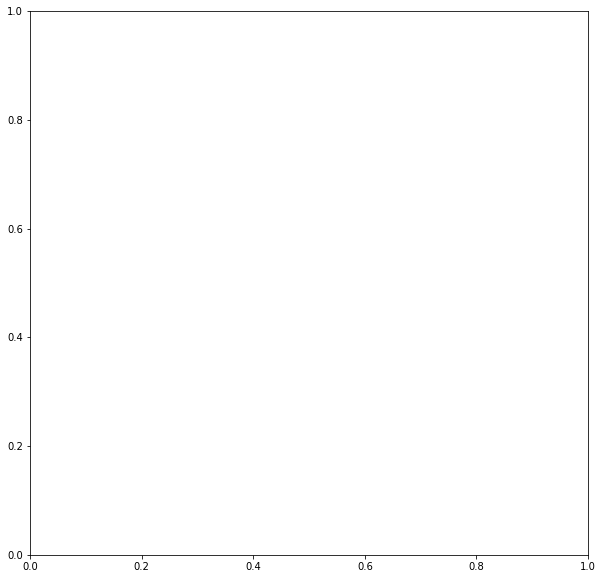

In [71]:

%matplotlib agg
fig, ax = plt.subplots(figsize=(10,10))
def animate(ts):
    ax.clear()
    wait_range = [120,300,600,1200,1800,2700,3600,1000000]
    s = 0
    gdf_list = []
    for e in wait_range:
        gdf_list.append(gdf_stop_activity[(gdf_stop_activity['hr']==ts)&(gdf_stop_activity['avg_waittime']>=s)&(gdf_stop_activity['avg_waittime']<e)])
        s = e
    i = -1
    for gdf in gdf_list:
        i = i + 1
        if i == 0:
            st_wait = 0
        else:
            st_wait = wait_range[i-1]/60
        lbl=str(int(st_wait))+' - '+str(int(wait_range[i]/60))+' min'
        gdf.plot(ax=ax, color=rgb(0,len(gdf_list),i), markersize = 1, label=lbl)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=4,markerscale=8)
    ax.text(0.6,0.9,ts,transform=ax.transAxes)
    
        
        

In [72]:
%matplotlib inline

ts = gdf_stop_activity['hr'].unique()
ts.sort()
ani = animation.FuncAnimation(fig, animate, frames=ts)

In [73]:
HTML(ani.to_jshtml(fps=0.5))

<Figure size 432x288 with 0 Axes>

In [26]:
wait_range = [120,300,600,1200,1800,2700,3600,1000000]

In [27]:
wait_range[0]

120

In [30]:
i = 0
if i = 1:
    st_wait = 0
else:
    st_wait = wait_range[i-1]/60
print(str(st_wait)+' - '+str(wait_range[i]/60)+' min')

16666.666666666668 - 2.0 min


In [45]:
i = -1
for _ in range(0,len(wait_range)):
    i = i + 1
    if i == 0:
        st_wait = 0
    else:
        st_wait = int(wait_range[i-1]/60)
    lbl=str(st_wait)+' - '+str(int(wait_range[i]/60))+' min'
    print(lbl)

0 - 2 min
2 - 5 min
5 - 10 min
10 - 20 min
20 - 30 min
30 - 45 min
45 - 60 min
60 - 16666 min


In [41]:
wait_range[0]

120